# Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
!pip install --upgrade reedsolo
import reedsolo as rs

# About QR codes
###### *Main reference:* &nbsp;&nbsp; https://en.wikipedia.org/wiki/QR_code
###### *Useful illustration video:* &nbsp;&nbsp; https://youtu.be/KA8hDldvfv0
###### *A more thorough reference:* &nbsp;&nbsp; https://en.wikiversity.org/wiki/Reed%E2%80%93Solomon_codes_for_coders
###### *An even more thorough reference:* &nbsp;&nbsp; https://www.thonky.com/qr-code-tutorial

<br/>
<br/>

First, let's see what a QR code is made up of...

![Structure of a QR code (version 7), highlighting functional elements.](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/QR_Code_Structure_Example_3.svg/1280px-QR_Code_Structure_Example_3.svg.png)
> *Structure of a QR code (version 7), highlighting functional elements.*

<br/>
<br/>

## 1. Version Information
The top-right finder pattern cell has a short field of data that is contained there. This lets us know which QR code version is being scanned.

The two blue version information boxes in the example image above are mirror images of each other.

Version and format information is doubly redundant in QR codes.
## 2. Format information

The red format information next to the bottom locator box matches the format information below the top left locator box, and the red format information below the top right locator box matches the format information to the right of the top left locator box.

Version and format information is doubly redundant in QR codes.

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/1024px-QR_Format_Information.svg.png)
> *Meaning of format information.*

<br/>
<br/>

## 3. Data (incl. error correction)
The message that the QR code includes, with error correction redundancy.

![Message placement within a Ver 1 QR symbol (21×21).](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png)
> *Message placement within a Ver 1 QR symbol (21×21).*

<br/>
<br/>

## 4. Other patterns
### 4.1. Position (locator/finder) pattern
The three large squares ("locator boxes") at the corners of the QR code give you enough information about the location and overall orientation of the QR code. They are 7x7 black and white cells, surrounded by white padding wrt their position.

If you can identify those three squares in an image, then you have identified that a QR code exists within their contour.
### 4.2 Alignment pattern
This pattern of squares ensures that you get the orientation of the QR code right, in case it is tilted or skewed.
### 4.3 Timing pattern
This L-shaped pattern connects the three squares. A damaged QR code can still be read because of the timing pattern, which enables the reader to distinguish between specific squares within the entire code.

It is composed of alternating black and white pixels, starting with a black pixel right after the locator box white border.
## 5. Quiet Zone
This is the perimeter of a QR code. It is blank (white).

A QR reader needs this border to distinguish what is and isn't contained in the QR code (due to interference from outside elements).

# Example

## Import and binarize
Must make sure that the image is full of 0s or 255s for further processing

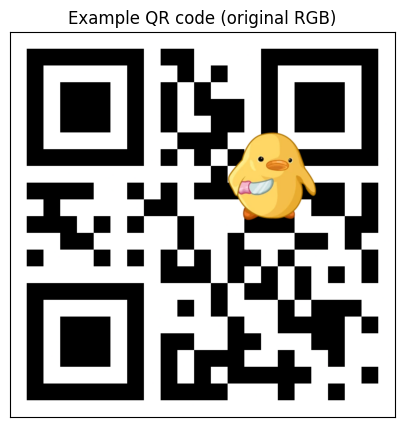

In [ ]:
img = cv2.cvtColor(cv2.imread("QR_1_Hello.png"), cv2.COLOR_RGB2BGR)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code (original RGB)')
plt.imshow(img, cmap='gray');

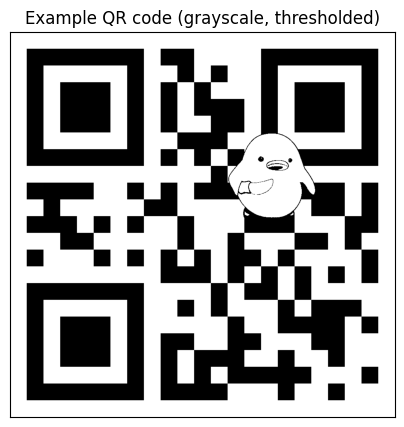

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
_, img = cv2.threshold(img, 142, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code (grayscale, thresholded)')
plt.imshow(img, cmap='gray');

## Use quiet zone to detect code area
Simply go through white rows and columns until you find the first black pixel from the left, from the right, from the top, and from the bottom.

In [ ]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

print(start_row, end_row, start_col, end_col)

44 968 44 968


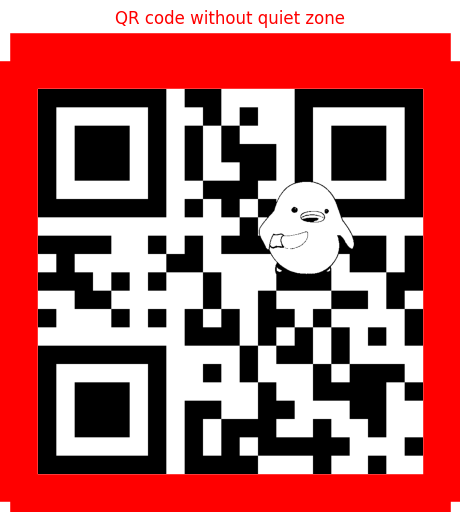

In [ ]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
fig.get_axes()[0].spines[:].set_color('red');
fig.get_axes()[0].spines[:].set_linewidth(40);
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y = 1.15, color='red');
plt.imshow(qr_no_quiet_zone, cmap='gray');

## Use locator boxes to determine grid size
Since we know that the topleft pixel should be the border of the locator box, and that its size should be 7×7, we can determine the grid cell size by dividing its size in pixels by 7. How to get its size? It is a constant black row of pixels followed by one white cell. A simple for loop can get it done.

In [ ]:
size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1

print(size)

308


In [ ]:
# Therefore the grid cell size is..
grid_cell_size = round(size/7)
print(grid_cell_size)

44


In [ ]:
# And it each row/column is expected to have the following no. of qr_cells
grid_cells_num = round(qr_no_quiet_zone.shape[0]/grid_cell_size)
print(grid_cells_num)

21


In [ ]:
# So now it is time to split the following shape...
print(qr_no_quiet_zone.shape)

(924, 924)


In [ ]:
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

(21, 21, 44, 44)


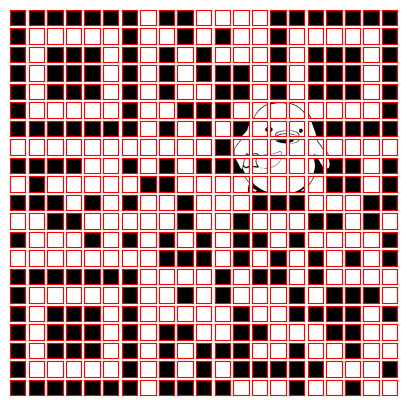

In [ ]:
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color('red')

## Convert grid tiles to numeric values

In [ ]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

print(qr_cells_numeric)

[[0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0]
 [1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0]
 [0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0]
 [1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1]
 [0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1]
 [0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1]
 [0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1]
 [0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1]]


## Information extraction

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png)
> *Meaning of format information.*

### Error correction level

In [ ]:
# We want row #8
qr_cells_numeric[8]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0],
      dtype=uint8)

In [ ]:
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not(c)) for c in qr_cells_numeric[8, 0:2]]
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)

[1, 1]


### Mask pattern

In [ ]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = ''.join([str(c) for c in mask])
print(mask_str)

110


### Format error correction

In [ ]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(not(c)) for c in fec]
print(fec)

[0, 0, 1, 0, 1, 1, 1, 0, 0, 1]


In [ ]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1, 1] [1, 1, 0] [0, 0, 1, 0, 1, 1, 1, 0, 0, 1]


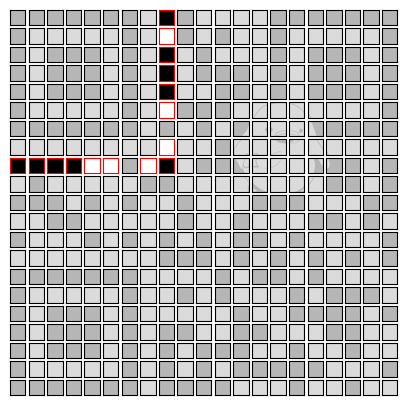

In [ ]:
# Let's cross-check with our example
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            if (i != 6) and (j != 6):
                col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                col.spines[:].set_color('red')
                continue
        col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)

In [ ]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

[0, 1] [0, 1, 1] [0, 0, 1, 0, 1, 0, 1, 0, 1, 1]


## Data extraction

![Message placement within a Ver 1 QR symbol (21×21).](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png)
> *Message placement within a Ver 1 QR symbol (21×21). Example from wikipedia, encoded QR message is www.wikipedia.org*

In [ ]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result

### Data encoding

In [ ]:
enc_bits = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
enc_int = int(''.join([str(bit) for bit in enc_bits]), 2)
print(f'{enc_bits} = Byte encoding (8 bits per character)')
# 0001	Numeric encoding (10 bits per 3 digits)
# 0010	Alphanumeric encoding (11 bits per 2 characters)
# 0100	Byte encoding (8 bits per character)
# 1000	Kanji encoding (13 bits per character)
# ...

[0, 1, 0, 0] = Byte encoding (8 bits per character)


### Data length

In [ ]:
len_bits = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'{len_bits} = {len_int} data symbols, each consisting of 8 bits')

[0, 0, 0, 1, 0, 0, 0, 1] = 17 data symbols, each consisting of 8 bits


### Data extraction (and error correction!)

In [ ]:
data_starting_indices = [
    [grid_cells_num-7,  grid_cells_num-1,  UP],    #    w    /     H
    [grid_cells_num-11, grid_cells_num-1,  CCW],   #    w    /     e
    [grid_cells_num-10, grid_cells_num-3,  DOWN],  #    w    /     l
    [grid_cells_num-6,  grid_cells_num-3,  DOWN],  #    .    /     l
    [grid_cells_num-2,  grid_cells_num-3,  CW],    #    w    /     o
    [grid_cells_num-3,  grid_cells_num-5,  UP],    #    i    /     ,
    [grid_cells_num-7,  grid_cells_num-5,  UP],    #    k    /  (space)
    [grid_cells_num-11, grid_cells_num-5,  CCW],   #    i    /     Q
    [grid_cells_num-10, grid_cells_num-7,  DOWN],  #    p    /     R
    [grid_cells_num-6,  grid_cells_num-7,  DOWN],  #    e    /  (space)
    [grid_cells_num-2,  grid_cells_num-7,  CW],    #    d    /     W
    [grid_cells_num-3,  grid_cells_num-9,  UP],    #    i    /     o
    [grid_cells_num-7,  grid_cells_num-9,  UP],    #    a    /     r
    [grid_cells_num-11, grid_cells_num-9,  UP],    #    .    /     l
    [grid_cells_num-16, grid_cells_num-9,  UP],    #    o    /     d
    [grid_cells_num-20, grid_cells_num-9,  CCW],   #    r    /     !
    [grid_cells_num-19, grid_cells_num-11, DOWN],  #    g    /     1
    [grid_cells_num-14, grid_cells_num-11, DOWN],  # End of message (Terminator)
    [grid_cells_num-12, grid_cells_num-11, DOWN],  # E1
    [grid_cells_num-8,  grid_cells_num-11, DOWN],  # E2
    [grid_cells_num-4,  grid_cells_num-11, DOWN],  # E3
    [grid_cells_num-9,  grid_cells_num-13, UP],    # E4
    [grid_cells_num-12, grid_cells_num-16, DOWN],  # E5
    [grid_cells_num-9,  grid_cells_num-18, UP],    # E6
    [grid_cells_num-12, grid_cells_num-20, DOWN],  # E7
]

message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
extracted_data_no_error_correction = ''
for a, b, d in data_starting_indices:  # For each starting index and direction
    bits = apply_mask(a, b, d)  # Extract the bits per the indexed QR code symbol
    bit_string = ''.join([str(bit) for bit in bits])  # Convert to string of bits
    alpha_char = chr(int(bit_string, 2))  # Convert binary to int, then to a char
    if bit_string[:4] == "0000":  # If the first 4 bits are 0s, this is the END
        print(f'{bit_string[:4]}...         = NULL TERMINATOR (END Symbol, SKIP!)')
        message_bits.extend(bits[:4])  # Append only the four bits
    else:  # If not the END symbol, append full set of bits
        message_bits.extend(bits)
        extracted_data_no_error_correction += alpha_char
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')

print(f'\ni.e., the data and ECCs in the QR code as-is are "{extracted_data_no_error_correction}"')

# For every 8 bits in the extracted message, convert to a byte
message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

# Create the Reed-Solomon Codec for 7 ECC symbols
rsc = rs.RSCodec(nsym=7)

# Decode the bytes with the 7-ECC RS Codec
message_decoded = rsc.decode(message_bytes)
print('\nNow decoding...\n')
rsc.maxerrata(verbose=True)
print(f'Decoded message = "{message_decoded[0].decode(encoding="iso-8859-1")}"')
print(f'Decoded ECCs    = "{message_decoded[1][-7:].decode(encoding="iso-8859-1")}"')

# In order to extract the actual data, need to convert back to bits and...
# ...remove the initial 12 bits (enc and len) and last 4 bits (terminator)
data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:-4]

# Now convert back to bytes and print it lol
data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
print(f'Data should be... "Hello, QR World!1" - and yes there\'s a \'1\' after the \'!\'')

01001000 (=072) = H
01100101 (=101) = e
01101100 (=108) = l
01101100 (=108) = l
01101111 (=111) = o
00101100 (=044) = ,
00100000 (=032) =  
01010001 (=081) = Q
01010010 (=082) = R
00100000 (=032) =  
01010111 (=087) = W
01101111 (=111) = o
01110010 (=114) = r
01100100 (=100) = d
01100100 (=100) = d
00100001 (=033) = !
00110001 (=049) = 1
0000...         = NULL TERMINATOR (END Symbol, SKIP!)
00000101 (=005) = 
01011111 (=095) = _
11100000 (=224) = à
11111001 (=249) = ù
10011011 (=155) = 
00110101 (=053) = 5
10110010 (=178) = ²
11111000 (=248) = ø

i.e., the data and ECCs in the QR code as-is are "Hello, QR Wordd!1_àù5²ø"

Now decoding...

This codec can correct up to 3 errors and 7 erasures independently
Decoded message = "AVÆÆòÂ"v÷&ÆB"
Decoded ECCs    = "_àù5²ø"
Data in message = "Hello, QR World!1"
Data should be... "Hello, QR World!1" - and yes there's a '1' after the '!'


# Another (more summarized) example

00110001 (=049) = 1
01110001 (=113) = q
01100001 (=097) = a
01111010 (=122) = z
00100001 (=033) = !
01010001 (=081) = Q
01000001 (=065) = A
01011010 (=090) = Z
01000000 (=064) = @
01010111 (=087) = W
01010011 (=083) = S
01011000 (=088) = X
00101111 (=047) = /
01011100 (=092) = \
00100111 (=039) = '
01011011 (=091) = [
01011101 (=093) = ]
0000...         = NULL TERMINATOR (END Symbol, SKIP!)
00001101 (=013) = 
11010111 (=215) = ×
10010100 (=148) = 
10111110 (=190) = ¾
11000111 (=199) = Ç
10110011 (=179) = ³
01110011 (=115) = s
01001100 (=076) = L
Data in message = "qaz!QAZ@WSX/\'[]"
Data should be... "1qaz!QAZ@WSX/\'[]"


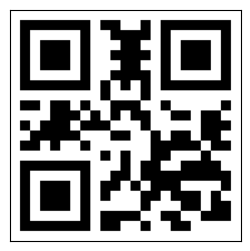

In [ ]:
img = cv2.imread("QR_2_Symbols.png", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img, cmap='gray')

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]

size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1

grid_cell_size = round(size/7)
grid_cells_num = round(qr_no_quiet_zone.shape[0]/grid_cell_size)
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)

qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

mask = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = ''.join([str(c) for c in mask])

mask[0] ^= 1
mask[2] ^= 1

message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    if bit_string[:4] == "0000":
        print(f'{bit_string[:4]}...         = NULL TERMINATOR (END Symbol, SKIP!)')
        message_bits.extend(bits[:4])
    else:
        message_bits.extend(bits)
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')

message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

rsc = rs.RSCodec(nsym=7)
message_decoded = rsc.decode(message_bytes)

data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:-4]
data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')

print(f'Data in message = "{data_bytes[1:].decode(encoding="iso-8859-1")}"')
print(f'Data should be... "1qaz!QAZ@WSX/\\\'[]"')

<hr/>

Now your job is to include redundant data, look into the error correcting mechanism(s), and perhaps look into newer QR code versions (although that will probably be too difficult, so keep that as a challenge if you find everything else easy). *Good luck :)*

**Here's for example the structure of a version 3 QR code:**
![Version 3 QR Code illustrating interleaved Reed-Solomon blocks](https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/QR_Ver3_Codeword_Ordering.svg/1280px-QR_Ver3_Codeword_Ordering.svg.png)
> Version 3 QR Code illustrating interleaved Reed-Solomon blocks

# Yet another example on Version 1

## Preprocessing

(21, 21)


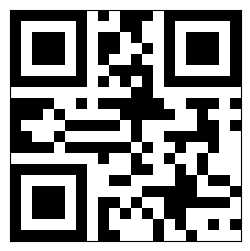

In [ ]:
_, img3 = cv2.threshold(cv2.imread("QR_3_a.png", cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY);

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img3):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img3[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img3.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img3)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img3)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img3.shape[1] - col_index
            break
    if end_col != -1:
        break

img3_no_quiet_zone = img3[start_row:end_row, start_col:end_col]

# Alternative method to get the grid directly
# I directly resize it to 21x21 and use something like the replacement downscaling geometric transformation
# So for each collection of pixels, only one pixel survives, and since this is a perfect test case, it works
# In non-perfect test cases, you'd have needed to do some more steps to ensure correct replacement is done
img3_21x21_grid = cv2.resize(img3_no_quiet_zone, (21, 21), interpolation=cv2.INTER_AREA) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img3_21x21_grid, cmap='gray');
print(img3_21x21_grid.shape)

This time I will invert the entire grid before proceeding, to abide by the QR Code's convention of setting black cells to 1 and white to 0.

In [ ]:
img3_21x21_grid_inv = 1 - img3_21x21_grid

## QR Format Extraction

In [ ]:
ecl = img3_21x21_grid_inv[8, 0:2]
mask = img3_21x21_grid_inv[8, 2:5]
# I don't care about FEC because I know this is a perfect test case
# However, you! should care (the FEC is what tells you whether the format bits are correct or not)
# I will leave it up to you to check for their correctness via decoding or a lookup table
# Since this time I won't demonstrate the FEC concept, I don't need to apply the FEC mask
# Thus, these are our ECL and MASK values:
print(ecl, mask)
# Remember, regarding the ECL value, we choose from the following:
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.

[1 1] [1 1 0]


## Data Extraction

In [ ]:
# Dictionary of all masks and their equivalent formulae
# P.S. I modified them to account for that I skipped the FEC mask part above
# If you will do it, do not XOR the mask if you wish to use this MASKS table
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}
# Enum for the different directions of reading blocks in the QR code
# The number indicates how many bytes are in this block
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [ ]:
# A more general apply_mask function (still works the same way)
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [ ]:
enc_bits = apply_mask_general(21-1, 21-1, img3_21x21_grid_inv, mask, UP8)[:4]
print(enc_bits)
# 0001	Numeric encoding (10 bits per 3 digits)
# 0010	Alphanumeric encoding (11 bits per 2 characters)
# 0100	Byte encoding (8 bits per character)
# 1000	Kanji encoding (13 bits per character)
# ...

[0, 1, 0, 0]


In [ ]:
len_bits = apply_mask_general(21-3, 21-1, img3_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'{len_bits} = {len_int} data symbols, each consisting of 8 bits')

[0, 0, 0, 0, 0, 0, 0, 1] = 1 data symbols, each consisting of 8 bits


In [ ]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [ ]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
# Let me re-format this for better readability :)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img3_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

01100001 (=097) = a


You're probably gonna say "is that it?" and, yes, this QR code literally only contains the letter 'a'.

In [ ]:
# After finishing all the characters, the next 4 bits are expected to be '0000'
start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img3_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
print(bits)
byte_index += 1

[0, 0, 0, 0, 1, 1, 1, 0]


Indeed, the first four bits are '0000'.. What do we do now?

In [ ]:
# Let's see what the bytes that follow look like
# There supposedly remain 25-2=23 bytes to be read
for _ in range(23):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img3_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
0001 (=001) = 
11011010 (=218) = Ú
00101000 (=040) = (
11110011 (=243) = ó
11010100 (=212) = Ô
01000010 (=066) = B
01000111 (=071) = G
10010110 (=150) = 


This is interesting, the QR code filled the rest of the data bits with a pattern of 0s and 1s, I guess that is how it "pads" data when data is finished but it is not yet the time for the ECCs to come in. Okay. Cool. Whatever. Let's Reed-Solomon now please?

In [ ]:
# For every 8 bits in the extracted message, convert to a byte
message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

# Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
rsc = rs.RSCodec(nsym=7)

# Decode the bytes with the 7-ECC RS Codec
message_decoded = rsc.decode(message_bytes)
rsc.maxerrata(verbose=True)

# In order to extract the actual data, need to convert back to bits
# Then take as many bytes as indicated by the message length indicator
# That is AFTER removing the first 12 bytes (of enc and len)
data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]

# Now convert back to bytes and print it lol
data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
print(f'Data should be... "a"')

This codec can correct up to 3 errors and 7 erasures independently
Data in message = "a"
Data should be... "a"


# Yalla one more habibi

(21, 21)


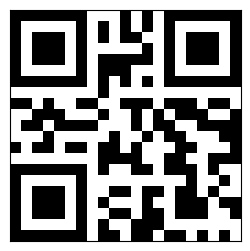

In [ ]:
_, img4 = cv2.threshold(cv2.imread("01-Getting-started.png", cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY);

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img4):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img4[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img4.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img4)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img4)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img4.shape[1] - col_index
            break
    if end_col != -1:
        break

img4_no_quiet_zone = img4[start_row:end_row, start_col:end_col]
img4_21x21_grid = cv2.resize(img4_no_quiet_zone, (21, 21), interpolation=cv2.INTER_AREA) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img4_21x21_grid, cmap='gray');
print(img4_21x21_grid.shape)

In [ ]:
img4_21x21_grid_inv = 1 - img4_21x21_grid
ecl = img4_21x21_grid_inv[8, 0:2]
mask = img4_21x21_grid_inv[8, 2:5]
enc_bits = apply_mask_general(21-1, 21-1, img4_21x21_grid_inv, mask, UP4)
len_bits = apply_mask_general(21-3, 21-1, img4_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [1 1]
MASK = [0 1 0]
ENC = [0, 1, 0, 0]
LEN = [0, 0, 0, 0, 1, 1, 0, 0] = 12 data symbols, each consisting of 8 bits


In [ ]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img4_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1
# After finishing all the characters, the next 4 bits are expected to be '0000'
start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img4_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
bit_string = ''.join([str(bit) for bit in bits])
print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
byte_index += 1
# Let's see what the bytes that follow look like
# There supposedly remain 25-len-1 bytes to be read
for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img4_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

00110000 (=048) = 0
00110001 (=049) = 1
00101101 (=045) = -
01000111 (=071) = G
01101111 (=111) = o
01101111 (=111) = o
01100100 (=100) = d
00100000 (=032) =  
01101010 (=106) = j
01101111 (=111) = o
01100010 (=098) = b
00100001 (=033) = !
00001110 (=END) -- the NULL TERMINATOR, followed by padding and/or ECC
11000001 (=193) = Á
00011110 (=030) = 
11000001 (=193) = Á
00011110 (=030) = 
1100 (=012) = 
01000011 (=067) = C
00100111 (=039) = '
01011111 (=095) = _
00111011 (=059) = ;
11110011 (=243) = ó
10010001 (=145) = 
10011000 (=152) = 


In [ ]:
# For every 8 bits in the extracted message, convert to a byte
message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

# Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
rsc = rs.RSCodec(nsym=7)

# Decode the bytes with the 7-ECC RS Codec
message_decoded = rsc.decode(message_bytes)
rsc.maxerrata(verbose=True)

# In order to extract the actual data, need to convert back to bits
# Then take as many bytes as indicated by the message length indicator
# That is AFTER removing the first 12 bytes (of enc and len)
data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]

# Now convert back to bytes and print it lol
data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
print(f'Data should be... "01-Good job!"')

This codec can correct up to 3 errors and 7 erasures independently
Data in message = "01-Good job!"
Data should be... "01-Good job!"


Good job ***me***.